In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

In [198]:
data = pd.read_csv('/Users/shin-yoonhwan/vscode/stock_data/data_processor/input_model.csv')
grouped = data.groupby('Ticker')

In [199]:
def create_sequence(data, seq_length=10): # seq_length 튜닝변수로 사용
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :]) 
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [306]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_all = []
y_all = []

for ticker, group in grouped:
    group = group.drop(columns='Ticker')
    # 독립 변수와 종속 변수 분리
    X = group.drop(columns='close')  # 종속 변수를 제외한 나머지 열
    y = group[['close']]  # 종속 변수만 선택 (DataFrame으로 유지)

    # 스케일링
    X_scaled = X_scaler.fit_transform(X)  # 독립 변수 스케일링
    y_scaled = y_scaler.fit_transform(y)  # 종속 변수 스케일링

    # X와 y를 기반으로 시퀀스 생성
    X_seq, y_seq = create_sequence(np.hstack([X_scaled, y_scaled]), seq_length=10)
    X_all.append(X_seq)
    y_all.append(y_seq)

(5016, 10, 26)
torch.Size([5016, 10, 26])
Epoch 1/10, Train Loss: 0.6093223632513722
Epoch 2/10, Train Loss: 0.37348980484884
Epoch 3/10, Train Loss: 0.2752621600145026
Epoch 4/10, Train Loss: 0.23254045419677905
Epoch 5/10, Train Loss: 0.2127995095864127
Epoch 6/10, Train Loss: 0.205388058212739
Epoch 7/10, Train Loss: 0.19967863897356805
Epoch 8/10, Train Loss: 0.19351314838174022
Epoch 9/10, Train Loss: 0.18940551079149487
Epoch 10/10, Train Loss: 0.18527570432877238
Test Loss: 0.19887880217283965
'실제 값': f[142.08784], '예측 값' : [151.73007]'


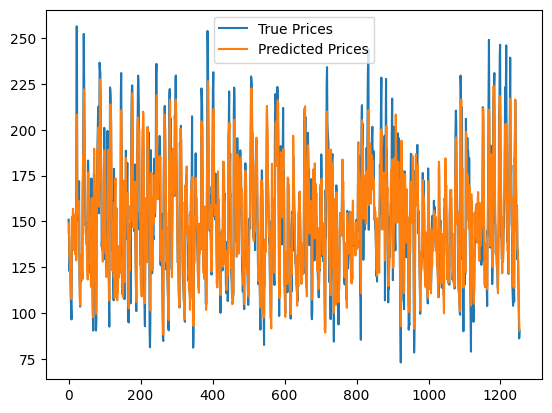

In [307]:


# X_all, y_all을 numpy 배열로 결합
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# 훈련/테스트 셋 나누기 (예시로 80% 훈련, 20% 테스트)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)
print(X_train.shape)
# LSTM은 3D 입력 (배치 크기, 시퀀스 길이, 특성 개수)를 요구
X_train = torch.tensor(X_train).float().reshape(-1, 10, 26)  # (배치 크기, 시퀀스 길이, 특성 개수)
X_test = torch.tensor(X_test).float().reshape(-1, 10, 26)
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
print(X_train.shape)

# DataLoader 생성
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# LSTM 모델 정의
class StockPredictionLSTM(nn.Module):
    def __init__(self, input_size=26, hidden_layer_size=50, output_size=1):
        super(StockPredictionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

# 모델, 손실 함수, 옵티마이저 정의
model = StockPredictionLSTM(input_size=26, hidden_layer_size=30, output_size=1)
criterion = nn.MSELoss()  # 평균 제곹 오차
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}")

# 모델 평가
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        test_loss += loss.item()
        

print(f"Test Loss: {test_loss/len(test_loader)}")

# 예측 결과
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_scaler.inverse_transform(y_pred.numpy())  # 역정규화
    y_test = y_scaler.inverse_transform(y_test.numpy().reshape(-1, 1))  # 실제값 역정규화
    print(f"'실제 값': f{y_test[10]}, '예측 값' : {y_pred[10]}'") 
    
# 예측 결과 시각화 (예시)
import matplotlib.pyplot as plt

plt.plot(y_test, label='True Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.show()

In [336]:
pred_data = data[data['Ticker'] == 'NVDA']
pred_data

,Ticker,PER,PBR,ROE,ROA,ROIC,Debt_ratio,매출액,영업이익,순이익,...,금리등락률,GDP,GDP등락률,유가,유가등락률,S&P500,close,volume,Market Cap,Sector_idx
25,NVDA,55.05,52.69,116.7,77.9,114.9,45.7,35082.0,21869.0,19309.0,...,-0.25,3.1,0.1,84.00,-1.26,562.01,132.8,5.627917e+09,3298803.0,4
26,NVDA,52.47,47.82,115.5,75.1,109.4,46.5,30040.0,18642.0,16599.0,...,0.00,3.0,1.4,85.26,3.96,534.01,132.8,5.627917e+09,3298803.0,4
27,NVDA,51.49,44.63,111.4,69.1,100.3,56.8,26044.0,16909.0,14881.0,...,0.00,1.6,-1.6,81.30,-2.24,521.21,117.0,6.405439e+09,3298803.0,4
28,NVDA,50.65,35.08,92.8,55.7,78.3,52.9,22103.0,13614.0,12285.0,...,0.00,3.2,-1.2,83.54,-3.18,469.33,86.4,1.007418e+10,3298803.0,4
29,NVDA,52.96,30.07,70.4,39.9,53.8,62.8,18120.0,10417.0,9243.0,...,0.25,4.4,2.0,86.72,8.92,443.37,61.5,9.706237e+09,3298803.0,4
30,NVDA,111.84,41.99,43.3,23.5,30.3,80.2,13507.0,6800.0,6188.0,...,2.50,2.4,-0.4,77.80,-2.55,493.28,40.8,1.014110e+10,3298803.0,4
31,NVDA,143.00,27.95,20.9,11.3,13.0,81.3,7192.0,2140.0,2043.0,...,-1.75,2.8,-0.6,80.35,-4.53,385.91,46.7,8.706845e+09,3298803.0,4
32,NVDA,114.69,22.67,18.7,10.3,11.7,86.3,6051.0,1256.0,1414.0,...,2.00,3.4,0.7,84.88,-12.03,393.28,27.7,7.436450e+09,3298803.0,4
33,NVDA,57.83,16.14,24.3,13.7,15.2,89.6,5931.0,601.0,680.0,...,0.75,2.7,2.4,96.91,-11.17,406.60,19.5,9.454960e+09,3298803.0,4
34,NVDA,58.66,19.04,30.8,17.8,19.8,82.3,6704.0,499.0,656.0,...,1.25,0.3,1.3,108.08,12.49,389.80,13.5,1.254928e+10,3298803.0,4


In [337]:
pred_data = pred_data.drop(columns=['Ticker'])
X = pred_data.drop(columns= 'close')
y = pred_data[['close']]  # 종속 변수를 제외한 나머지 열

model.eval()
# 스케일링
X_scaled_pred = X_scaler.transform(X)
y_scaled_pred = y_scaler.transform(y)  # 독립 변수 스케일링  # 스케일링
X_y_data = np.hstack([X_scaled_pred, y_scaled_pred])
# 시퀀스 생성 및 차원 맞추기
seq_length = 10
X_y_data = X_y_data[:10]  # seq_length만큼 가져오기
X_y_data = X_y_data.reshape(1, seq_length, X_y_data.shape[1])

input_tensor = torch.tensor(X_y_data, dtype=torch.float32)
print(input_tensor)

# 예측 수행
with torch.no_grad():
    y_pred_pred = model(input_tensor)

# 예측값 역정규화 (타겟 변수의 스케일러 사용)
y_pred_pred_scaled = y_scaler.inverse_transform(y_pred_pred.numpy())
print("예측된 값:", y_pred_pred, )

tensor([[[ 2.5811e+00,  1.2220e+01,  9.1191e+00,  4.7568e+01,  4.1930e+01,
          -2.8558e+00,  1.2035e+02,  1.4955e+02,  1.7724e+02,  6.1594e+01,
           3.9438e+01,  5.9786e+01,  9.6119e+01, -1.0736e+01, -2.0594e+01,
           1.4187e+00, -4.5015e-01,  3.2903e-02,  5.0023e-03,  6.7121e-01,
          -1.8614e-01,  1.6441e+00,  4.2359e+02,  3.2244e+06, -6.0000e+00,
          -7.3754e-01],
         [ 2.1581e+00,  1.0442e+01,  8.9493e+00,  4.5465e+01,  3.9425e+01,
          -2.8448e+00,  1.0206e+02,  1.2680e+02,  1.5172e+02,  5.3578e+01,
           3.3693e+01,  5.2318e+01,  7.8458e+01, -7.7044e+00, -1.6581e+01,
           1.5454e+00, -1.4599e-01,  2.2220e-02,  9.0568e-02,  7.4234e-01,
           3.9583e-01,  1.3999e+00,  4.2359e+02,  3.2244e+06, -6.0000e+00,
          -7.3754e-01],
         [ 1.9974e+00,  9.2771e+00,  8.3691e+00,  4.0958e+01,  3.5280e+01,
          -2.7039e+00,  8.7573e+01,  1.1457e+02,  1.3554e+02,  4.7518e+01,
           3.5316e+01,  4.3623e+01,  8.3280e+01, -1.